In [1]:
# imports
import pandas as pd                              # it's pandas
import Constants as c                           # constants
import Functions as f                           # plotting functions
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import pickle
import folium
import hdbscan as hdbs
from math import radians


In [2]:
# Import dataframe from "out" folder
with open('../out/TREAD_out.pkl', 'rb') as file:
    df, trips_list, name_of_route = pickle.load(file)
# pick one random trip to fiddle with it
sample_trip = trips_list[73]
display(f"There are in total {df['trip_id'].max() + 1} separate trips")

'There are in total 45384 separate trips'

In [3]:
# some info about the dataframe
sample_trip.reset_index(inplace=True, drop=True)
# the above instruction sometimes adds a new column called 'index', which is subsequently removed
if 'index' in sample_trip.columns:
    print("Column \"Index\" removed")
    sample_trip.drop(['index'], axis=1, inplace=True)
display(sample_trip.head(3))
#display(df)
# current columns (aka features) of the dataset
print(df.columns)
display(df.info())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,Draft,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,trip_id
0,367745320,2019-01-22 00:04:54,20.7428,-156.8866,8.5,98.4,107.0,EXPEDITIONS SIX,60,15,...,NaN,True,5.27,sailing,None,<NA>,WP_61 - WP_96,True,1,29564
1,367745320,2019-01-22 00:05:58,20.7403,-156.8825,19.0,121.5,125.0,EXPEDITIONS SIX,60,15,...,NaN,True,15.48,sailing,WP_61,<NA>,WP_61 - WP_96,True,0,29564
2,367745320,2019-01-22 00:07:20,20.7370,-156.8761,18.4,96.2,95.0,EXPEDITIONS SIX,60,15,...,NaN,True,18.04,sailing,None,<NA>,WP_61 - WP_96,True,0,29564


Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'VesselType', 'Status', 'Length', 'Width', 'Draft',
       'IsClassA', 'Avg_Speed', 'EstimatedStatus', 'IsInWP',
       'IsInSignificantWP', 'Route', 'IsInRoute', 'group', 'trip_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 5460702 entries, 0 to 2
Data columns (total 22 columns):
 #   Column             Dtype        
---  ------             -----        
 0   MMSI               int32        
 1   BaseDateTime       datetime64[s]
 2   LAT                float64      
 3   LON                float64      
 4   SOG                float64      
 5   COG                float64      
 6   Heading            float64      
 7   VesselName         string       
 8   VesselType         int16        
 9   Status             int8         
 10  Length             int16        
 11  Width              int16        
 12  Draft              float32      
 13  IsClassA           bool   

None

#### General Approach
1. Normalization (some features have different scales) (to be decided, probably not)
2. Features selection
3. Algorithm

In [4]:
# check which columns contain any null values
df.isnull().sum()

MMSI                       0
BaseDateTime               0
LAT                        0
LON                        0
SOG                        0
COG                        0
Heading                    0
VesselName            456248
VesselType                 0
Status                     0
Length                     0
Width                      0
Draft                3618047
IsClassA                   0
Avg_Speed                  0
EstimatedStatus            0
IsInWP               1278778
IsInSignificantWP    1734711
Route                      0
IsInRoute                  0
group                      0
trip_id                    0
dtype: int64

,trip_id,count
0,2411,180
1,2404,83
2,5580,62
3,29413,49
4,29829,48
...,...,...
282,30323,21
283,30246,20
284,30321,20
285,29962,14


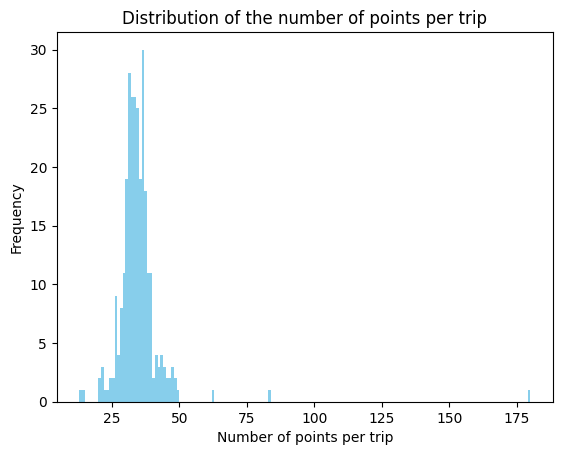

In [5]:
# all the trips of the chosen route are separated in a list
# create a single dataframe with all of them together
testDF = pd.concat(trips_list, ignore_index=True, axis=0)
points_per_trip = testDF['trip_id'].value_counts().reset_index(name='count')

display(points_per_trip)

plt.figure()
plt.hist(points_per_trip['count'], 
         bins=range(min(points_per_trip['count']), max(points_per_trip['count']) + 1, 1), # from, to, step
         color='skyblue')
plt.xlabel('Number of points per trip')
plt.ylabel('Frequency')
plt.title('Distribution of the number of points per trip')
plt.show()

Text(0.5, 1.0, 'Fit Values: 33.68 and 5.50')

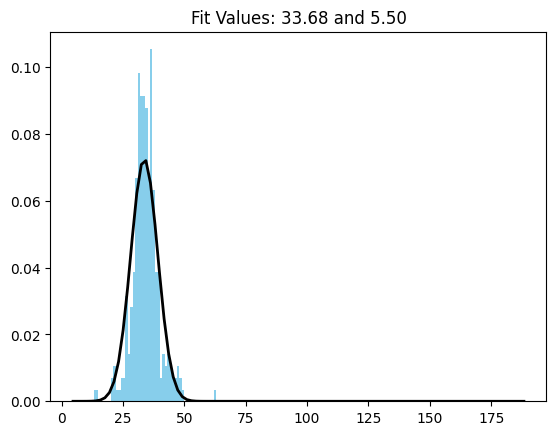

In [6]:
import scipy.stats as stats
# try to extract normal distribution
points_data = points_per_trip['count']
points_data = points_data[points_data < 80].values # manually remove outliers
mu, std = stats.norm.fit(points_data)

plt.hist(points_data, 
         bins=range(min(points_per_trip['count']), max(points_per_trip['count']) + 1, 1),
         density=True,
         color='skyblue'
         )

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

In [7]:
plot = f.route_arrows_plot(inputDF=testDF, color_criteria='Avg_Speed', scale_factor=0.0001)
po.plot(plot, auto_open=True)

'temp-plot.html'

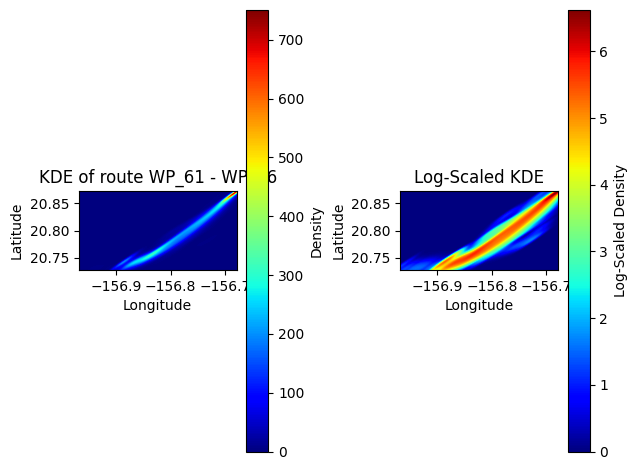

In [8]:
from scipy.stats import gaussian_kde
# Perform KDE

x = testDF['LON']
y = testDF['LAT']

kde = gaussian_kde([x,y])
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# create a grid of points
x_grid, y_grid = np.linspace(xmin, xmax, 500), np.linspace(ymin, ymax, 500)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])
# Z is a matrix that contains the estimated density values at each grid point
# defined by x_grid and y_grid
Z = np.reshape(kde(positions).T, X.shape)

# plot kde result on map
fig, axes = plt.subplots(1,2)
im1 = axes[0].imshow(
    Z,
    origin='lower',
    #aspect='auto',
    extent=[xmin, xmax, ymin, ymax],
    cmap='jet'
)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(f'KDE of route {testDF.at[0, "Route"]}')
fig.colorbar(im1, ax=axes[0], label="Density")

# Show normalized scale
Z_log = np.log1p(Z)
im2 = axes[1].imshow(Z_log,
            origin='lower',
            #aspect='auto',
            extent=[xmin, xmax, ymin, ymax],
            cmap='jet'
           )
axes[1].set_title('Log-Scaled KDE')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
fig.colorbar(im2, ax=axes[1], label="Log-Scaled Density")

plt.tight_layout()
plt.show()

In [9]:
# Calculate x and y components of speed starting from known values of SOG and COG
# System of equations (as written in the paper): 1) SOG^2 = Vx^2 + Vy^2, 2) COG = arctan((Vy)/(Vx))
# For equation #2, there is an issue as arctan is hard to invert. So instead of using this system of equations, we can use another one:
# New system of equations: 1) Vx = SOG * cos(COG), 2) Vy = SOG * sin(COG)

# First step: convert true north COG angles into standard arithmetic angles.
# Formula: X = (450 - COG) mod 360 
# https://community.safe.com/general-10/how-to-convert-arithmetic-angles-to-geographic-angles-18164

testDF['A_COG'] = (450 - testDF['COG']) % 360
display(testDF['A_COG'].head(3))
# convert the arithmetic angles in radians
testDF['A_COG'] = testDF['A_COG'].apply(radians)
display(testDF['A_COG'].head(3))
# calculate Vx and Vy
testDF['V_x'] = testDF['SOG'] * np.cos(testDF['A_COG'])
testDF['V_y'] = testDF['SOG'] * np.sin(testDF['A_COG'])
display(testDF[['V_x', 'V_y']].head(3))

# compare with points on map:
plot = f.route_arrows_plot(inputDF=testDF.head(3).copy(), color_criteria='Avg_Speed', scale_factor=0.0001)
po.plot(plot, auto_open=True)

0    333.7
1      2.8
2     25.8
Name: A_COG, dtype: float64

0    5.824164
1    0.048869
2    0.450295
Name: A_COG, dtype: float64

,V_x,V_y
0,6.185756,-3.057191
1,6.292479,0.307754
2,6.032136,2.916048


'temp-plot.html'

In [10]:
#another test
testDF = p.concat(trips_list, ignore_index=True, axis=0)
chosen_columns = ['LAT', 'LON', 'Avg_Speed', 'COG', 'Heading']
#chosen_columns = ['LAT', 'LON', 'Avg_Speed', 'COG', 'Heading', 'IsClassA']
chosen_data = testDF[chosen_columns]

from sklearn.mixture import GaussianMixture

lowest_bic = np.inf
best_gmm = None
n_clusters_range = range(1,11)


for cluster_num in n_clusters_range:
    gmm = GaussianMixture(n_components= cluster_num, random_state = 0)
    gmm.fit(chosen_data)
    bic = gmm.bic(chosen_data)

    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm

testDF['cluster'] = best_gmm.predict(chosen_data)

map = folium.Map(location=[testDF.LAT.mean(), testDF.LON.mean()], zoom_start=12)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

#plot
f.route_plot(inputDF=testDF, color_criteria='cluster', hover_data=chosen_columns, title=f'Route {name_of_route}')
# TODO fix this function below 
#f.route_clusters_plot(testDF)

AttributeError: 'numpy.ndarray' object has no attribute 'concat'

In [ ]:
# Select biggest clusters until 80% of points is reached
testDF['cluster'].value_counts()
total_points = testDF['cluster'].size
eighty_percent = int(total_points * 0.8)
display(total_points, eighty_percent)

groupedDF = testDF.groupby(by='cluster').size().reset_index(name='count',).sort_values(by='count', ascending=False)
groupedDF.reset_index(drop=True, inplace=True)
display(groupedDF)

partial_sum = 0
for index, row in groupedDF.iterrows():
    temp_value = row['count']
    if partial_sum + temp_value > eighty_percent:
        break
    else:
        partial_sum = partial_sum + temp_value

selected_clusters = groupedDF.iloc[:index+1, 0].to_list()

display(selected_clusters)

f.route_plot(testDF[testDF['cluster'].isin(selected_clusters)], color_criteria='cluster')
f.route_plot(testDF[testDF['cluster'].isin(set(groupedDF['cluster'].to_list()) - set(selected_clusters))], color_criteria='cluster')

9861

7888

,cluster,count
0,9,5003
1,0,2179
2,2,772
3,6,727
4,5,548
5,3,290
6,1,183
7,4,81
8,7,47
9,8,31


[9, 0, 2]

##### Test with hdbscan

In [ ]:
testDF = p.concat(trips_list, ignore_index=True, axis=0)
chosen_columns = ['LAT', 'LON', 'Avg_Speed', 'COG', 'Heading', 'IsClassA']
chosen_data = testDF[chosen_columns]

# inizitalize h-dbscan object with parameters. TODO: test multiple parameters combinations
h_dbscan = hdbs.HDBSCAN(min_cluster_size=30,
                        cluster_selection_epsilon=0.01,
                        max_cluster_size=10_000)

h_labels = h_dbscan.fit_predict(
                    X=testDF[['LAT','LON']]
                    )

print(str(h_dbscan) + " len: " + str(len(h_labels)) + ", num of clusters: " + str(max(h_labels)))

# Add labels to the dataframe
testDF['Label'] = h_labels

display(testDF)

# Show the result of h-dbscan on a map

clusteredPointsDF = testDF[(testDF['Label'] != -1)].copy()
outliersDF = testDF[testDF['Label'] == -1].copy()

clusteredPointsDF = clusteredPointsDF.groupby(by=['LAT', 'LON', 'Label']).size().reset_index(name='Weight')

# plot points and clusters
f.points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=h_dbscan)


HDBSCAN(cluster_selection_epsilon=0.01, max_cluster_size=10000,
        min_cluster_size=30) len: 9861, num of clusters: 1


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,...,IsClassA,Avg_Speed,EstimatedStatus,IsInWP,IsInSignificantWP,Route,IsInRoute,group,route_id,Label
0,338143427,2019-01-02 19:53:11,20.7387,-156.8818,6.9,116.3,511.0,KOA,36,99,...,False,6.38,sailing,WP_61,<NA>,WP_61 - WP_96,True,1,2404,0
1,338143427,2019-01-02 19:58:08,20.7386,-156.8725,6.3,87.2,511.0,KOA,36,99,...,False,6.34,sailing,None,<NA>,WP_61 - WP_96,True,0,2404,0
2,338143427,2019-01-02 19:59:10,20.7391,-156.8707,6.7,64.2,511.0,KOA,36,99,...,False,6.13,sailing,None,<NA>,WP_61 - WP_96,True,0,2404,0
3,338143427,2019-01-02 20:00:10,20.7401,-156.8690,6.8,51.2,511.0,KOA,36,99,...,False,6.77,sailing,None,<NA>,WP_61 - WP_96,True,0,2404,0
4,338143427,2019-01-02 20:02:08,20.7418,-156.8659,3.2,73.6,511.0,KOA,36,99,...,False,6.16,sailing,None,<NA>,WP_61 - WP_96,True,0,2404,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9856,367745320,2019-03-31 21:10:27,20.8593,-156.6950,21.2,51.3,52.0,EXPEDITIONS SIX,60,15,...,True,20.64,sailing,WP_96,<NA>,WP_61 - WP_96,True,0,30323,1
9857,367745320,2019-03-31 21:11:32,20.8635,-156.6897,21.7,54.9,56.0,EXPEDITIONS SIX,60,15,...,True,21.62,sailing,WP_96,<NA>,WP_61 - WP_96,True,0,30323,1
9858,367745320,2019-03-31 21:16:20,20.8708,-156.6802,3.7,8.9,18.0,EXPEDITIONS SIX,60,15,...,True,8.64,sailing,WP_96,<NA>,WP_61 - WP_96,True,0,30323,1
9859,367745320,2019-03-31 21:17:32,20.8720,-156.6792,0.7,119.5,332.0,EXPEDITIONS SIX,60,15,...,True,4.57,sailing,WP_96,<NA>,WP_61 - WP_96,True,0,30323,1
